# Objective:
The goal of this project is to support underwriters in developing a risk scoring system based on historical insurance claim data. By identifying clients who have a higher probability of making a claim, underwriters can make more informed decisions when negotiating policy terms, such as adjusting premiums or coverage levels to better manage risk.



In [1]:
# Import necessary libraries
import random, pickle, optuna, warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from collections import defaultdict
from collections import Counter
from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

sns.set()
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
def generate_insurance_dataset(n_samples=10000, positive_class_ratio=0.35, random_state=42):
    """Function to create a synthetic data for this usecase."""
    np.random.seed(random_state)
    random.seed(random_state)

    def _generate_features(n):
        data = {}

        # Numerical features
        data['age'] = np.random.normal(loc=40, scale=12, size=n).astype(int)
        data['income'] = np.random.normal(loc=50000, scale=15000, size=n).astype(int)
        data['credit_score'] = np.clip(np.random.normal(loc=680, scale=70, size=n), 300, 850).astype(int)
        data['num_dependents'] = np.random.poisson(2, n)
        data['year_employed'] = np.random.randint(0, 41, n)
        data['savings'] = np.random.normal(loc=10000, scale=7000, size=n).astype(int)
        data['monthly_expenses'] = np.random.normal(loc=2500, scale=800, size=n).astype(int)
        data['debt_to_income'] = np.round(np.random.uniform(0, 1, n), 2)

        # Categorical features
        data['gender'] = np.random.choice(['Male', 'Female', 'Other'], n)
        data['marital_status'] = np.random.choice(['Single', 'Married', 'Divorced', 'Widowed'], n)
        data['education_level'] = np.random.choice(['High School', 'Bachelors', 'Masters', 'PhD'], n)
        data['occupation'] = np.random.choice(['Clerk', 'Manager', 'Engineer', 'Teacher', 'Unemployed'], n)
        data['vehicle_type'] = np.random.choice(['Sedan', 'SUV', 'Truck', 'None'], n)
        data['region'] = np.random.choice(['North', 'South', 'East', 'West'], n)
        data['policy_type'] = np.random.choice(['Basic', 'Standard', 'Premium'], n)

        # Ordinal/Binary features with probabilities
        data['health_status'] = np.random.choice(['Poor', 'Average', 'Good', 'Excellent'], n, p=[0.2, 0.4, 0.3, 0.1])
        data['driving_record'] = np.random.choice(['Bad', 'Average', 'Good'], n, p=[0.1, 0.4, 0.5])
        data['home_ownership'] = np.random.choice(['Rent', 'Own', 'Mortgage'], n, p=[0.3, 0.4, 0.3])
        data['customer_loyalty'] = np.random.choice([1, 2, 3, 4, 5], n, p=[0.1, 0.2, 0.3, 0.3, 0.1])
        data['has_criminal_record'] = np.random.choice([0, 1], n, p=[0.95, 0.05])

        # Generate random extra features to reach 40 total
        existing_cols = len(data)
        for i in range(existing_cols + 1, 41):
            data[f'feature_{i}'] = np.random.randn(n)

        return pd.DataFrame(data)

    def _map_ordinal_features(df):
        mappings = {
            'health_status': {'Poor': 0, 'Average': 1, 'Good': 2, 'Excellent': 3},
            'driving_record': {'Bad': 0, 'Average': 1, 'Good': 2},
            'home_ownership': {'Rent': 0, 'Mortgage': 1, 'Own': 2},
        }
        for col, map_dict in mappings.items():
            df[f'{col}_num'] = df[col].map(map_dict)
        return df

    def _generate_target(df, ratio):
        score = (
            0.02 * df['age'] +
            -0.00003 * df['income'] +
            -0.01 * df['credit_score'] +
            -0.1 * df['driving_record_num'] +
            -0.2 * df['health_status_num'] +
            -0.1 * df['home_ownership_num'] +
            -0.1 * df['has_criminal_record'] +
            -0.03 * df['customer_loyalty'] +
            np.random.normal(0, 1, len(df))
        )
        threshold = np.percentile(score, 100 - (ratio * 100))
        df['claim_status'] = (score > threshold).astype(int)
        return df.drop(columns=['driving_record_num', 'health_status_num', 'home_ownership_num'])

    def _inject_missing_and_duplicates(df, missing_pct=0.01, dup_count=100):
        for col in df.columns:
            if col != 'claim_status':
                missing_indices = np.random.choice(len(df), size=int(missing_pct * len(df)), replace=False)
                df.loc[missing_indices, col] = np.nan
        dup_indices = np.random.choice(df.index, size=dup_count, replace=False)
        return pd.concat([df, df.loc[dup_indices]], ignore_index=True)

    # Assemble dataset
    df = _generate_features(n_samples)
    df = _map_ordinal_features(df)
    df = _generate_target(df, ratio=positive_class_ratio)
    df = _inject_missing_and_duplicates(df)

    return df

In [4]:
# Generate Data
df = generate_insurance_dataset()

In [5]:
df.head()

,age,income,credit_score,num_dependents,year_employed,savings,monthly_expenses,debt_to_income,gender,marital_status,education_level,occupation,vehicle_type,region,policy_type,health_status,driving_record,home_ownership,customer_loyalty,has_criminal_record,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,claim_status
0,45.0,39822.0,704.0,3.0,19.0,15201.0,2002.0,0.80,Other,Single,Masters,Teacher,None,South,Premium,Poor,Good,Own,5.0,0.0,-0.760158,3.772027,0.415966,0.258445,-1.416252,-0.590927,-0.594703,-0.867153,-0.716583,1.063678,-0.866002,-0.786139,1.041777,-1.053143,0.623120,-0.984074,1.281946,0.584370,-0.968003,-0.215245,1
1,38.0,45417.0,699.0,1.0,9.0,14718.0,2467.0,0.32,Female,Single,PhD,Unemployed,SUV,South,Basic,Good,Good,Own,4.0,0.0,1.140305,1.002477,-0.005939,0.637269,0.010635,0.621275,-1.142168,-1.269789,-0.529838,0.340936,0.227022,2.324090,1.661358,-1.126498,-0.791014,0.294868,-1.458005,1.323065,1.158261,-0.417599,0
2,47.0,41039.0,614.0,3.0,5.0,11286.0,1735.0,0.67,Other,Widowed,PhD,Teacher,SUV,West,Premium,Average,Average,Rent,NaN,0.0,1.354967,0.128944,NaN,-0.189095,-0.532632,1.174486,-0.000140,-1.150130,0.740565,-0.965878,0.626771,0.526959,0.195044,0.798625,-0.408430,-0.410630,1.068747,0.822363,-0.892726,-0.367684,1
3,58.0,51656.0,720.0,0.0,40.0,5185.0,3531.0,0.94,Other,Married,Bachelors,Unemployed,SUV,South,Basic,Good,Good,Own,4.0,0.0,-0.755445,0.785701,-0.102947,0.535111,1.754525,0.251059,0.059890,-0.071725,-0.314228,1.668112,-0.512217,1.028123,-0.938065,-0.535060,NaN,-1.147651,-1.148860,0.672146,0.655267,-0.771776,0
4,37.0,67957.0,575.0,2.0,32.0,22479.0,2010.0,0.71,Other,Divorced,High School,Unemployed,SUV,West,Standard,Good,Good,Rent,3.0,0.0,1.275296,0.321640,0.638299,-0.556104,-0.427602,1.090265,0.562604,1.024623,0.045659,0.292851,0.062264,0.389724,1.874346,-0.775180,-1.186322,1.331426,-0.702402,0.381069,0.494268,-0.413565,1


In [6]:
df.shape

(10100, 41)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9999 non-null   float64
 1   income               9999 non-null   float64
 2   credit_score         9999 non-null   float64
 3   num_dependents       10000 non-null  float64
 4   year_employed        10000 non-null  float64
 5   savings              10000 non-null  float64
 6   monthly_expenses     10000 non-null  float64
 7   debt_to_income       9999 non-null   float64
 8   gender               9999 non-null   object 
 9   marital_status       9999 non-null   object 
 10  education_level      9998 non-null   object 
 11  occupation           10000 non-null  object 
 12  vehicle_type         9999 non-null   object 
 13  region               10000 non-null  object 
 14  policy_type          9999 non-null   object 
 15  health_status        9998 non-null  

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,9999.0,39.522552,12.027152,-7.000000,31.000000,40.000000,48.000000,87.000000
income,9999.0,50169.239224,15019.832224,-7845.000000,40033.000000,50222.000000,60365.000000,109134.000000
credit_score,9999.0,678.423042,68.992342,424.000000,630.000000,679.000000,726.000000,850.000000
num_dependents,10000.0,1.994500,1.410982,0.000000,1.000000,2.000000,3.000000,10.000000
year_employed,10000.0,20.173000,11.885865,0.000000,10.000000,20.000000,31.000000,40.000000
savings,10000.0,10161.847300,6956.772083,-17612.000000,5438.000000,10202.000000,14884.750000,36996.000000
monthly_expenses,10000.0,2491.947800,806.010973,-577.000000,1948.000000,2501.500000,3039.000000,5780.000000
debt_to_income,9999.0,0.502196,0.288573,0.000000,0.250000,0.500000,0.750000,1.000000
customer_loyalty,9999.0,3.110911,1.138446,1.000000,2.000000,3.000000,4.000000,5.000000
has_criminal_record,9999.0,0.048705,0.215261,0.000000,0.000000,0.000000,0.000000,1.000000


In [9]:
# Drop duplicates
df = df.drop_duplicates(keep='first')

In [10]:
df.shape

(10000, 41)

In [11]:
df.isnull().sum()

age                    100
income                 100
credit_score           100
num_dependents         100
year_employed          100
savings                100
monthly_expenses       100
debt_to_income         100
gender                 100
marital_status         100
education_level        100
occupation             100
vehicle_type           100
region                 100
policy_type            100
health_status          100
driving_record         100
home_ownership         100
customer_loyalty       100
has_criminal_record    100
feature_21             100
feature_22             100
feature_23             100
feature_24             100
feature_25             100
feature_26             100
feature_27             100
feature_28             100
feature_29             100
feature_30             100
feature_31             100
feature_32             100
feature_33             100
feature_34             100
feature_35             100
feature_36             100
feature_37             100
f

In [12]:
# Check for class imbalance
df['claim_status'].value_counts(normalize=True)

claim_status
0    0.65
1    0.35
Name: proportion, dtype: float64

### EDA - Exploratory Data Analysis

In [14]:
# Selecting numerical columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
# Selecting categorical columns
cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()
print(num_cols)
print(cat_cols)

['age', 'income', 'credit_score', 'num_dependents', 'year_employed', 'savings', 'monthly_expenses', 'debt_to_income', 'customer_loyalty', 'has_criminal_record', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'claim_status']
['gender', 'marital_status', 'education_level', 'occupation', 'vehicle_type', 'region', 'policy_type', 'health_status', 'driving_record', 'home_ownership']


#####  Uni-variate Analysis

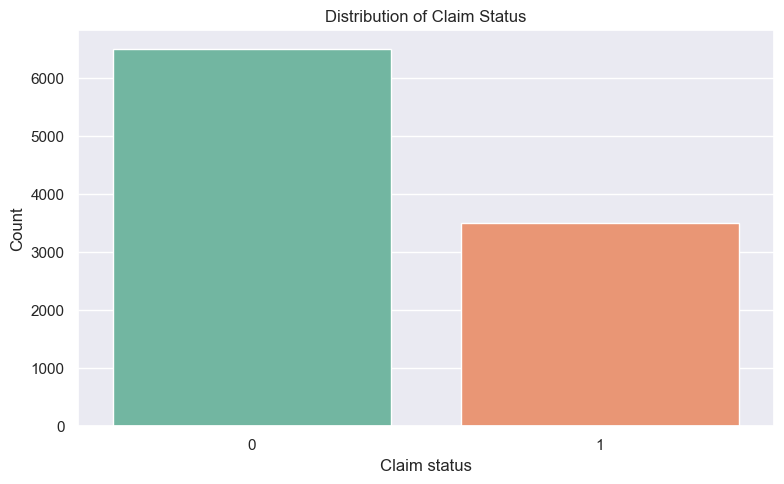

In [16]:
target_col = 'claim_status'
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=target_col, hue=target_col, palette="Set2", legend=False)

plt.xlabel('Claim status')
plt.ylabel('Count')
plt.title('Distribution of Claim Status')

plt.tight_layout()
plt.show()

##### Bi-variate analysis

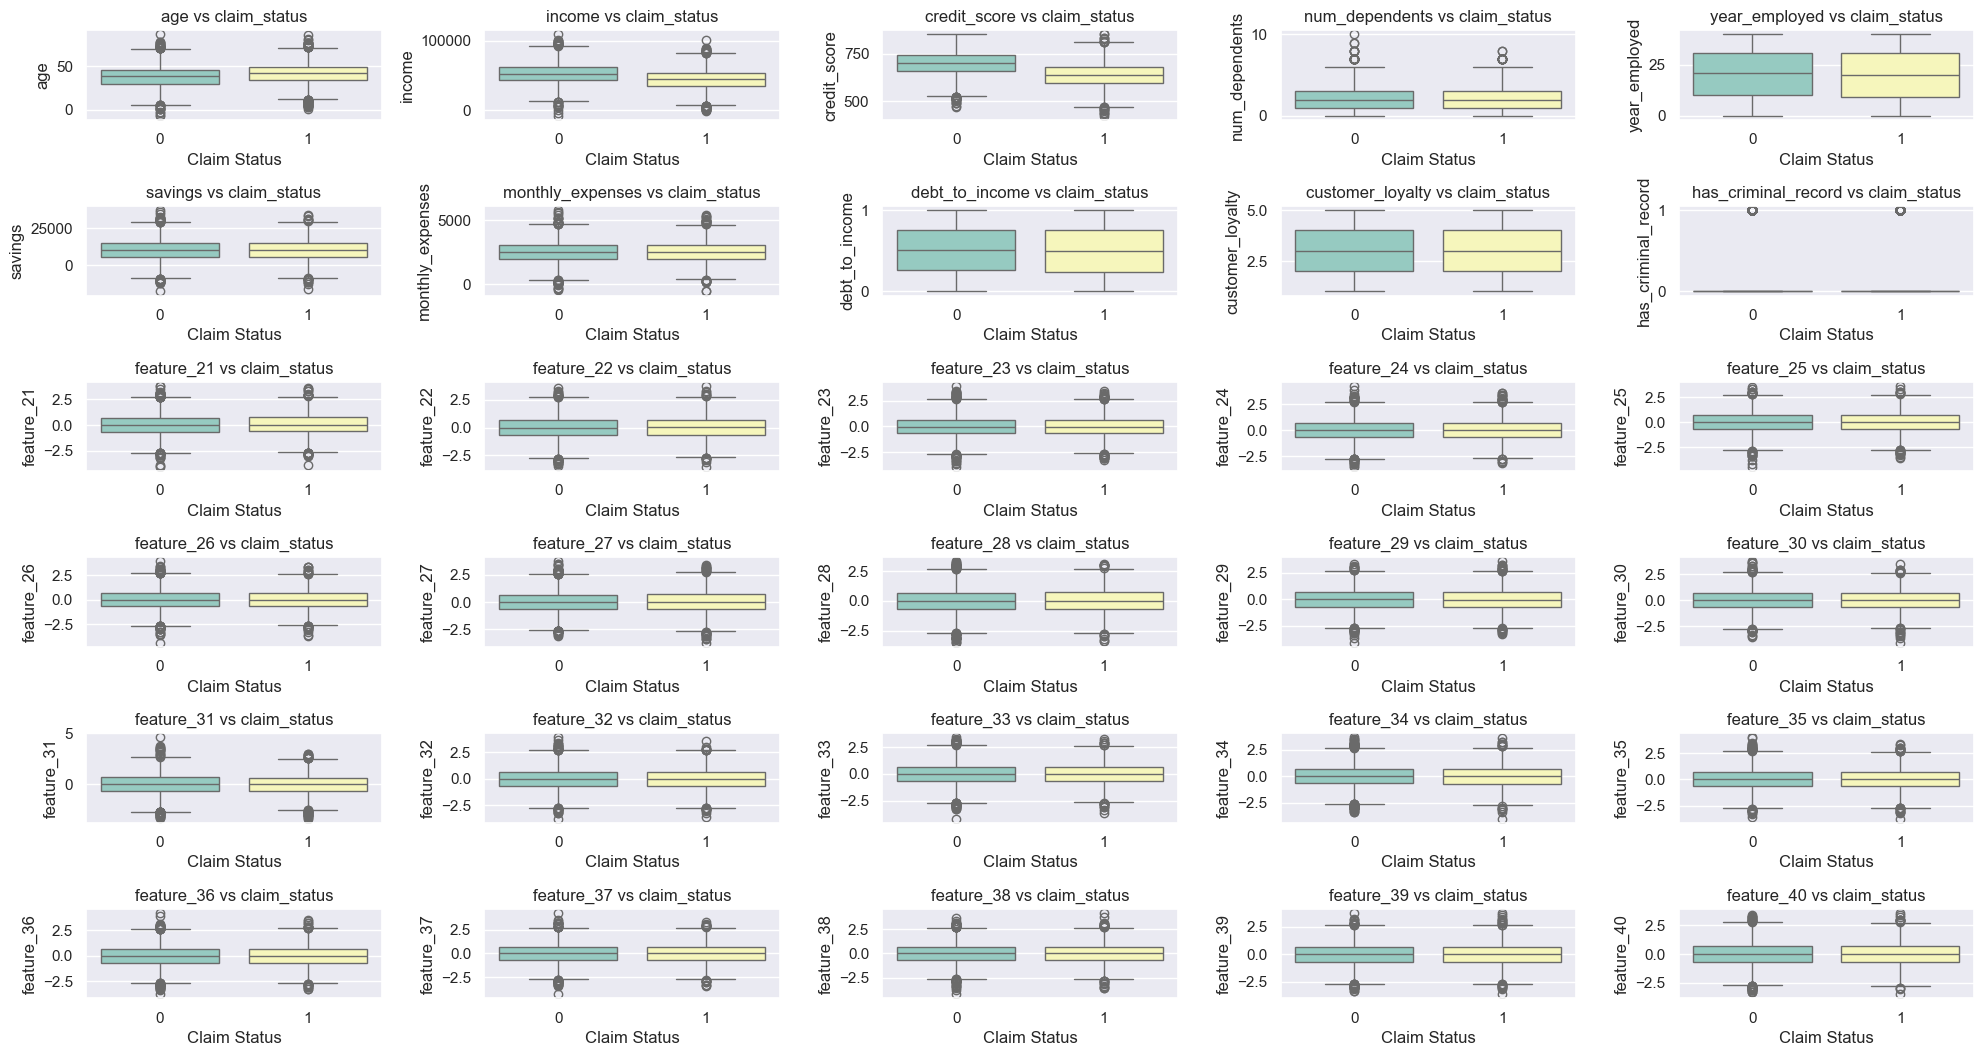

In [18]:
# Exclude the target
numerical_cols = [col for col in num_cols if col != 'claim_status']
target_col = 'claim_status'

# Set up the subplot grid (7 rows × 5 columns)
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 12))
axes = axes.flatten()

# Plot boxplots 
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x=target_col, y=col, hue=target_col, palette="Set3", legend=False, ax=axes[i])
    axes[i].set_title(f'{col} vs {target_col}')
    axes[i].set_xlabel('Claim Status')
    axes[i].set_ylabel(col)

# Hide any extra unused subplots
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

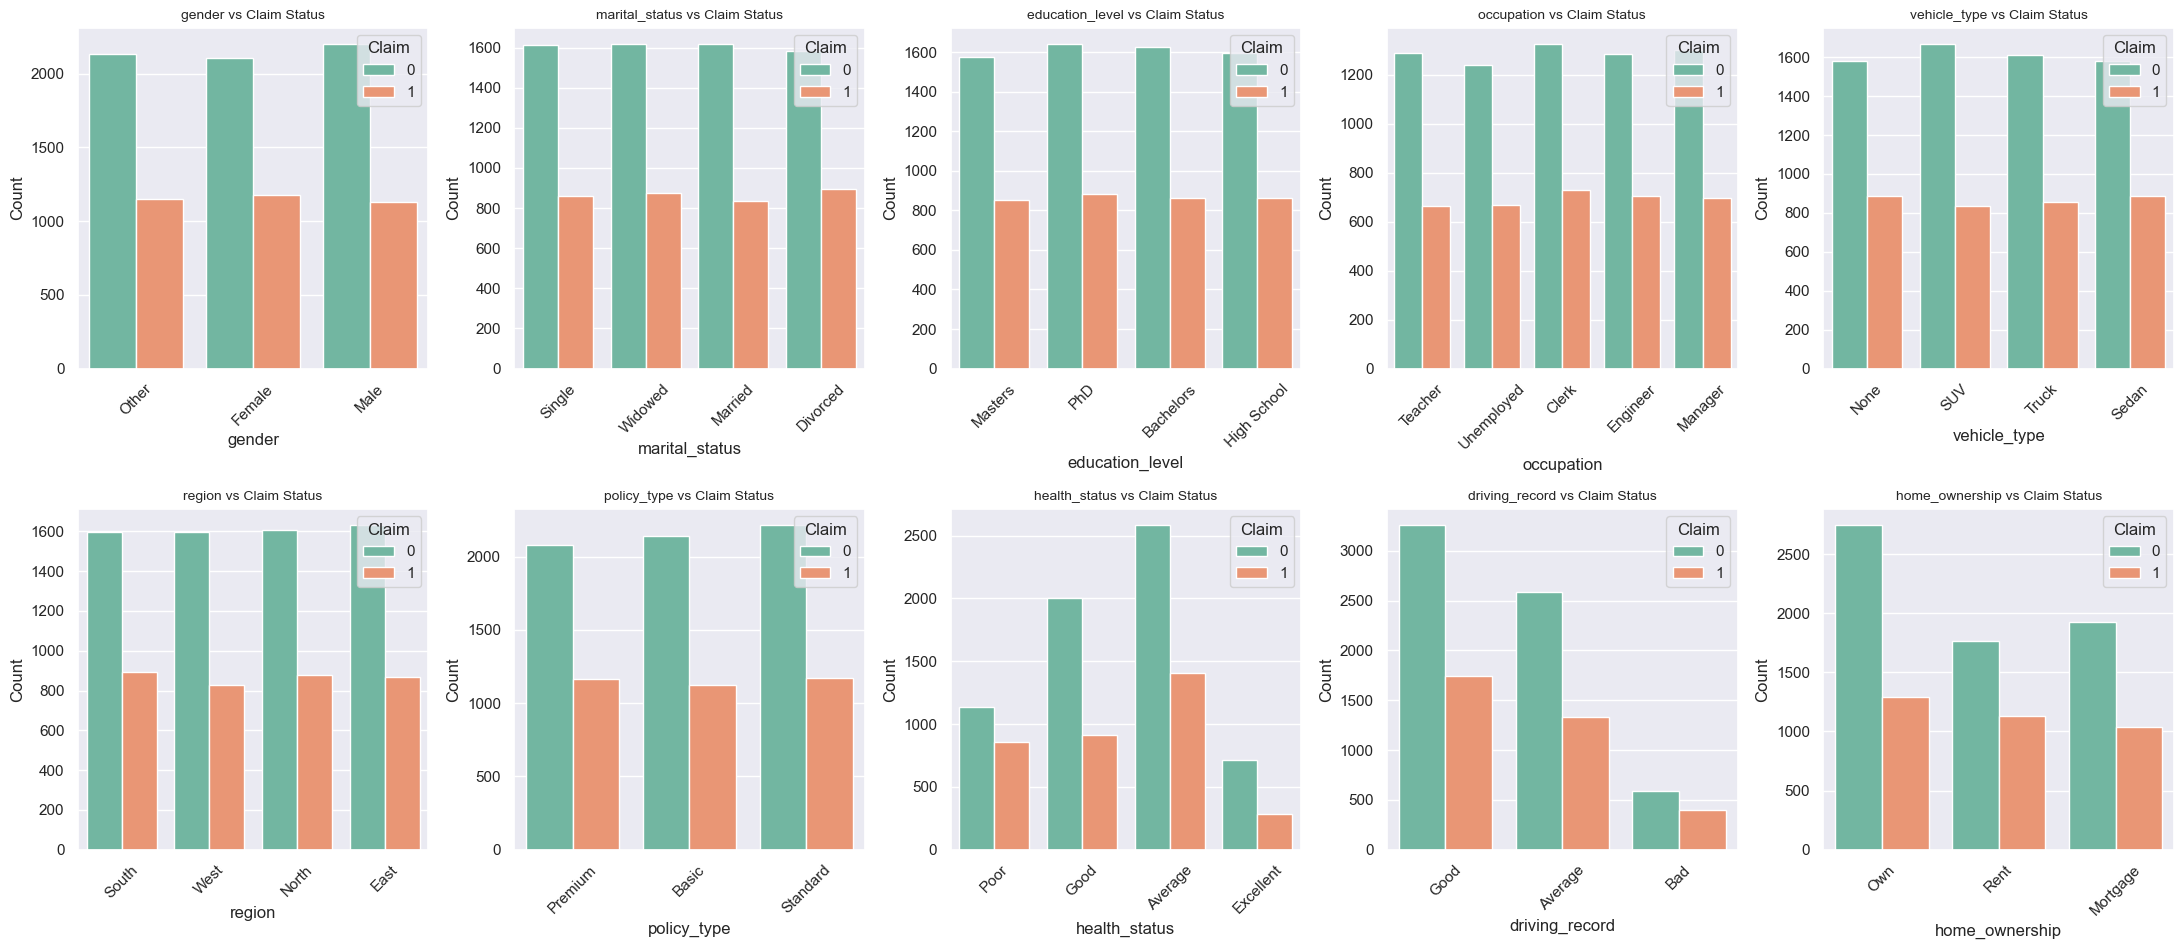

In [19]:
# Plot setup
n_cols = 5
n_rows = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 28))
axes = axes.flatten()

# Generate count plots
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, hue='claim_status', palette='Set2', ax=axes[i])
    axes[i].set_title(f'{col} vs Claim Status', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].legend(title="Claim", loc='best')

# Remove empty subplot if any
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Data Preprocessing Phase

In [21]:
# Lets drop the missing values since they are few observation
df.dropna(how='any', inplace=True)

In [22]:
# shuffle our data
df = shuffle(df, random_state=42)

In [23]:
# Split data into input and output objects
X = df.drop(['claim_status'], axis=1)
y = df['claim_status']

In [24]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# Handling categorical variable
cat_cols = ['gender', 'marital_status', 'education_level', 'occupation', 'vehicle_type', 'region', 'policy_type', 'health_status', 'driving_record', 'home_ownership']

ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

X_train_encoded = ohe.fit_transform(X_train[cat_cols])
X_test_encoded = ohe.transform(X_test[cat_cols])

encoder_feature_names = ohe.get_feature_names_out(cat_cols)

X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_train.drop(cat_cols, axis=1, inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)
X_test.drop(cat_cols, axis=1, inplace=True)

In [26]:
# Feature scaling with Normalization
scale_min = MinMaxScaler()
X_train = pd.DataFrame(scale_min.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scale_min.transform(X_test), columns=X_test.columns)

Optimal number of features: 11


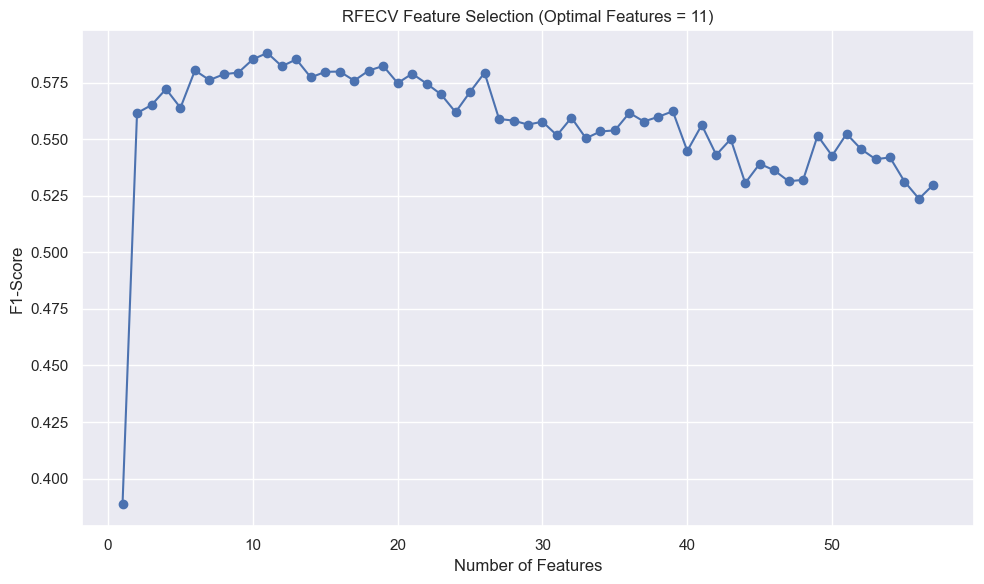

In [29]:
# Base estimator
clf = RandomForestClassifier(random_state=42)

# RFECV with recall as scoring
feature_selector = RFECV(estimator=clf, step=1, cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)

# Fit selector
fit = feature_selector.fit(X_train, y_train)

# Extract optimal features
optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

# Filter the training set to only selected features
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

# Plot recall vs number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1),
         fit.cv_results_['mean_test_score'], marker="o")
plt.ylabel("F1-Score")
plt.xlabel("Number of Features")
plt.title(f"RFECV Feature Selection (Optimal Features = {optimal_feature_count})")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
X_train.head()

,age,income,credit_score,savings,feature_27,feature_30,feature_31,feature_34,feature_35,feature_36,feature_37
0,0.606742,0.539587,0.539759,0.729217,0.564385,0.454544,0.704377,0.536440,0.732785,0.426363,0.399883
1,0.370787,0.465830,0.438554,0.696272,0.581631,0.802562,0.268872,0.800811,0.551924,0.540548,0.428960
2,0.573034,0.457960,0.496386,0.610366,0.659262,0.574923,0.348705,0.693957,0.582377,0.434550,0.581612
3,0.539326,0.827468,0.544578,0.569700,0.477939,0.556402,0.398819,0.507762,0.491433,0.559332,0.510691
4,0.404494,0.517167,0.787952,0.383120,0.541271,0.320958,0.432761,0.408562,0.458245,0.559540,0.527990


### Modelling Phase

In [32]:
# Model selection using optuna (Bayesian optimiser)

def find_best_models_using_optuna(X, y, n_trials=30):
    """Function to optimize different classifiers and get the optimal classifier for the usecase. """
    
    models = ['logistic_regression', 'decision_tree', 'random_forest', 'xgboost']
    results = []

    def get_objective(model_name):
        def objective(trial):
            if model_name == 'logistic_regression':
                params = {
                    'C': trial.suggest_float('C', 1e-3, 10.0, log=True),
                    'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
                    'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
                    'class_weight': 'balanced'
                }
                model = LogisticRegression(random_state=42, **params)

            elif model_name == 'decision_tree':
                params = {
                    'max_depth': trial.suggest_int('max_depth', 2, 30),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
                    'class_weight': 'balanced'
                }
                model = DecisionTreeClassifier(random_state=42, **params)

            elif model_name == 'random_forest':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_int('max_depth', 3, 30),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                    'class_weight': 'balanced'
                }
                model = RandomForestClassifier(random_state=42, **params)

            elif model_name == 'xgboost':
                params = {
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
                    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
                    'scale_pos_weight': 1
                }
                model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **params)

            else:
                raise ValueError(f"Unsupported model: {model_name}")

            score = cross_val_score(
                model, X, y,
                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                scoring='f1'
            ).mean()
            return score
        return objective

    for model_name in models:
        print(f"Tuning {model_name}...")
        study = optuna.create_study(direction='maximize')
        study.optimize(get_objective(model_name), n_trials=n_trials)

        results.append({
            'model': model_name,
            'best_score': study.best_value,
            'best_params': study.best_params
        })

    return pd.DataFrame(results)

In [33]:
results_df = find_best_models_using_optuna(X_train, y_train, n_trials=30)

[I 2025-05-09 16:45:13,818] A new study created in memory with name: no-name-c8756277-1929-4f98-a113-8af70c2e8177
[I 2025-05-09 16:45:13,849] Trial 0 finished with value: 0.0 and parameters: {'C': 0.008518039357661406, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2025-05-09 16:45:13,872] Trial 1 finished with value: 0.6520871497988582 and parameters: {'C': 0.1153935114595702, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.6520871497988582.
[I 2025-05-09 16:45:13,913] Trial 2 finished with value: 0.6506358753800381 and parameters: {'C': 7.904190422324936, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 1 with value: 0.6520871497988582.
[I 2025-05-09 16:45:13,947] Trial 3 finished with value: 0.6525231929967455 and parameters: {'C': 0.017596532972259507, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 3 with value: 0.6525231929967455.


Tuning logistic_regression...


[I 2025-05-09 16:45:14,080] Trial 4 finished with value: 0.6513222383536027 and parameters: {'C': 0.29210832016681004, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 3 with value: 0.6525231929967455.
[I 2025-05-09 16:45:14,139] Trial 5 finished with value: 0.6397476639149021 and parameters: {'C': 0.026852783634467463, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 3 with value: 0.6525231929967455.
[I 2025-05-09 16:45:14,180] Trial 6 finished with value: 0.6492010195759175 and parameters: {'C': 1.1822729785520838, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 3 with value: 0.6525231929967455.
[I 2025-05-09 16:45:14,226] Trial 7 finished with value: 0.6516211844262834 and parameters: {'C': 0.04650178798004772, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 3 with value: 0.6525231929967455.
[I 2025-05-09 16:45:14,248] Trial 8 finished with value: 0.6511182469633584 and parameters: {'C': 8.1370310866661, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 3 with v

Tuning decision_tree...


[I 2025-05-09 16:45:15,195] Trial 1 finished with value: 0.6375233069126055 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6375233069126055.
[I 2025-05-09 16:45:15,309] Trial 2 finished with value: 0.585456515849632 and parameters: {'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6375233069126055.
[I 2025-05-09 16:45:15,441] Trial 3 finished with value: 0.5544785691712538 and parameters: {'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6375233069126055.
[I 2025-05-09 16:45:15,479] Trial 4 finished with value: 0.5825922462144538 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 1 with value: 0.6375233069126055.
[I 2025-05-09 16:45:15,608] Trial 5 finished with value: 0.581844517920593 and para

Tuning random_forest...


[I 2025-05-09 16:45:33,469] Trial 0 finished with value: 0.6445061408833337 and parameters: {'n_estimators': 288, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 0 with value: 0.6445061408833337.
[I 2025-05-09 16:45:51,431] Trial 1 finished with value: 0.6327772172391134 and parameters: {'n_estimators': 273, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.6445061408833337.
[I 2025-05-09 16:45:54,874] Trial 2 finished with value: 0.6485142890310948 and parameters: {'n_estimators': 74, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 2 with value: 0.6485142890310948.
[I 2025-05-09 16:46:00,504] Trial 3 finished with value: 0.6497017584877548 and parameters: {'n_estimators': 295, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 3 with value: 0.6497017584877548.

Tuning xgboost...


[I 2025-05-09 16:47:21,463] Trial 0 finished with value: 0.6058412846269845 and parameters: {'max_depth': 4, 'learning_rate': 0.11674096094977185, 'n_estimators': 176, 'subsample': 0.7853876004377826, 'colsample_bytree': 0.899522939443806, 'reg_alpha': 2.023261095249993, 'reg_lambda': 4.3013897099682366}. Best is trial 0 with value: 0.6058412846269845.
[I 2025-05-09 16:47:21,968] Trial 1 finished with value: 0.5603786954463469 and parameters: {'max_depth': 8, 'learning_rate': 0.23727012663965552, 'n_estimators': 81, 'subsample': 0.6444517038149855, 'colsample_bytree': 0.7647143095493867, 'reg_alpha': 0.22937159118240347, 'reg_lambda': 0.7001535478979481}. Best is trial 0 with value: 0.6058412846269845.
[I 2025-05-09 16:47:22,749] Trial 2 finished with value: 0.5751726319684681 and parameters: {'max_depth': 8, 'learning_rate': 0.25486172346982633, 'n_estimators': 133, 'subsample': 0.7413194975347328, 'colsample_bytree': 0.6791038992715454, 'reg_alpha': 0.4469863514172284, 'reg_lambda': 

In [34]:
results_df

,model,best_score,best_params
0,logistic_regression,0.654408,"{'C': 0.08503412309649429, 'penalty': 'l2', 's..."
1,decision_tree,0.640153,"{'max_depth': 5, 'min_samples_split': 6, 'min_..."
2,random_forest,0.655234,"{'n_estimators': 105, 'max_depth': 9, 'min_sam..."
3,xgboost,0.612999,"{'max_depth': 3, 'learning_rate': 0.1429533726..."


In [37]:
best_params = results_df[results_df['model'] == 'random_forest']['best_params'].iloc[0]
best_params

{'n_estimators': 105,
 'max_depth': 9,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_features': 'log2'}

In [39]:
# Define the optimal classifier Randomforest
clf = RandomForestClassifier(random_state=42, **best_params)

# Fit the final classifier
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features='log2', min_samples_leaf=10,
                       min_samples_split=20, n_estimators=105, random_state=42)

### Evaluation Phase

In [58]:
# Predict and evaluate accuracy
preds = clf.predict(X_test)
final_acc = accuracy_score(y_test, preds)
y_pred_prob = clf.predict_proba(X_test)[:,1]    # Probability of the customer be in positive class 1

print("Final model accuracy on test set:", final_acc)

Final model accuracy on test set: 0.7603305785123967


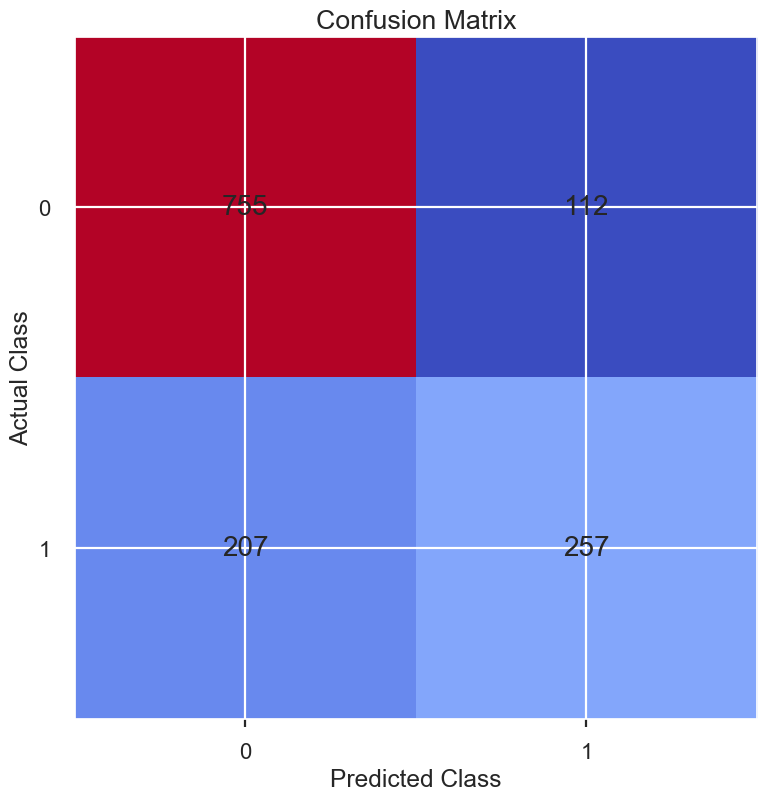

In [44]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)

plt.style.use('seaborn-v0_8-poster')
plt.matshow(conf_matrix, cmap='coolwarm')
plt.gca().xaxis.tick_bottom()
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
for (i, j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j, i, corr_value, ha='center', va='center', fontsize=20)
plt.show()

In [46]:
# Accuracy score(The number of correct classification out of all classifications)
accuracy_score(y_test, preds)

0.7603305785123967

In [48]:
# Precision score (Of all observations that were predicted as positive, how many were actually positive)
precision_score(y_test, preds)

0.6964769647696477

In [50]:
# Recall score (Of all positive observations, how many did we predict as positive)
recall_score(y_test, preds)

0.5538793103448276

In [52]:
# F1-Score (The harmonic mean of precision and recall)
f1_score(y_test, preds)

0.617046818727491

### Feature Importance plot

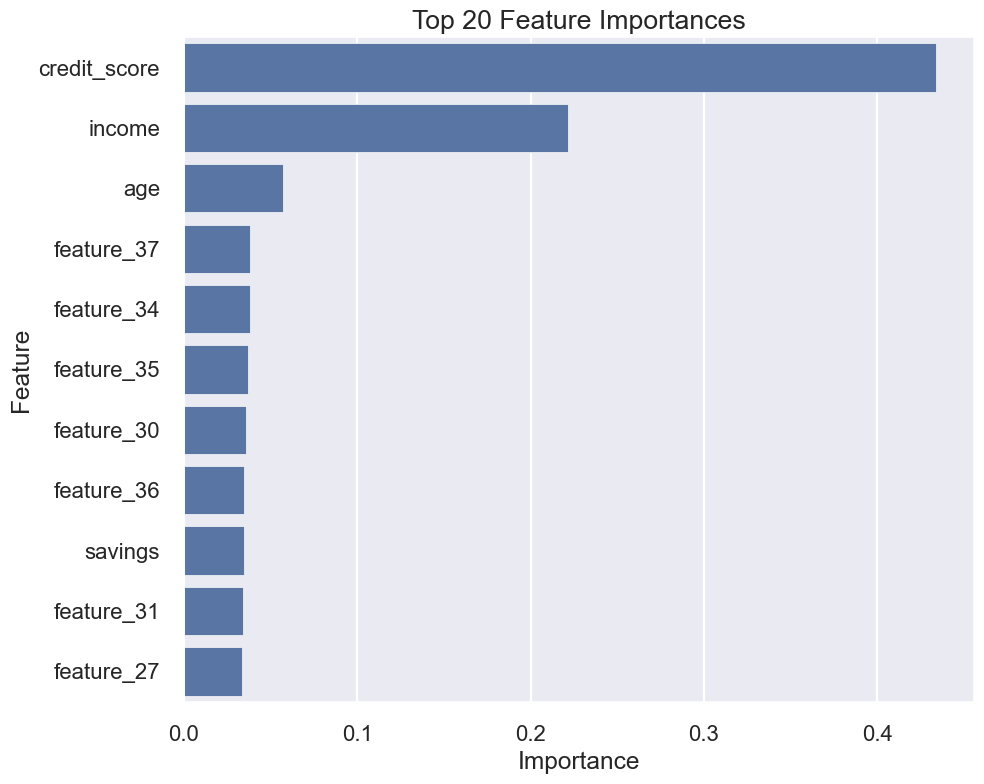

In [55]:
# Get feature importances
importances = clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

### Optimised threshold

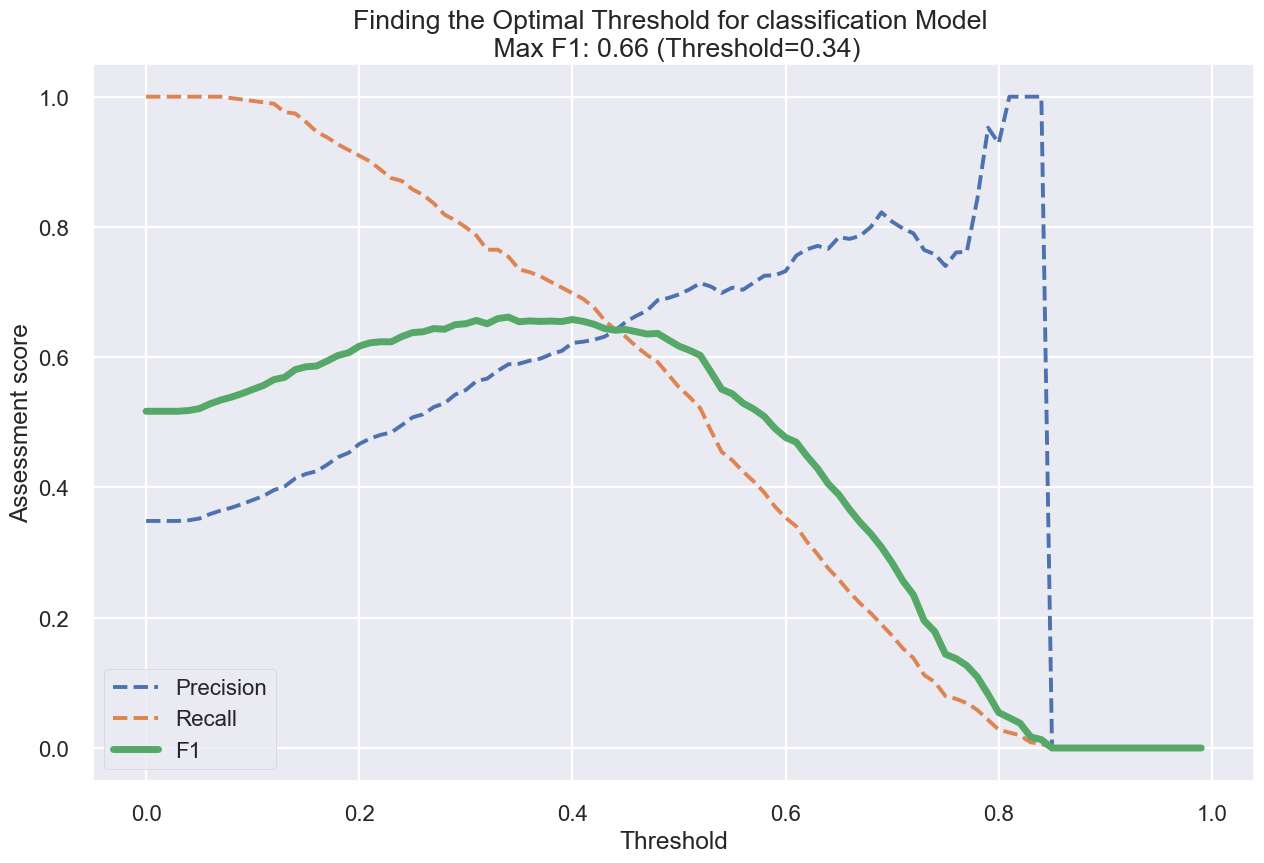

In [60]:
# Finding the optimal threshold (Maybe 50% is not the best threshold)
thresholds = np.arange(0, 1, 0.01)

precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    pred_class = (y_pred_prob >= threshold) * 1
    precision = precision_score(y_test, pred_class, zero_division=0)
    precision_scores.append(precision)

    recall = recall_score(y_test, pred_class)
    recall_scores.append(recall)

    f1 = f1_score(y_test, pred_class)
    f1_scores.append(f1)

max_f1 = max(f1_scores)
max_f1_idx = f1_scores.index(max_f1)
# Plot our chart
plt.style.use('seaborn-v0_8-poster')
plt.plot(thresholds, precision_scores, label='Precision', linestyle='--')
plt.plot(thresholds, recall_scores, label='Recall', linestyle='--')
plt.plot(thresholds, f1_scores, label='F1', linewidth=5)
plt.title(f"Finding the Optimal Threshold for classification Model \n Max F1: {round(max_f1, 2)} (Threshold={round(thresholds[max_f1_idx], 2)})")
plt.xlabel('Threshold')
plt.ylabel('Assessment score')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### Creating a risk score for the unseen data

In [65]:
# Assigning probabilies of making a claim to the test data
X_test['probabilities'] = y_pred_prob

In [67]:
X_test.head()

,age,income,credit_score,savings,feature_27,feature_30,feature_31,feature_34,feature_35,feature_36,feature_37,probabilities
0,0.303371,0.588408,0.650602,0.526223,0.455167,0.679469,0.390719,0.370888,0.485451,0.633892,0.366538,0.131182
1,0.584270,0.429364,0.720482,0.477974,0.536756,0.593659,0.561592,0.359918,0.452534,0.293941,0.288807,0.215796
2,0.505618,0.474149,0.681928,0.640460,0.708158,0.692165,0.475638,0.478585,0.545304,0.420219,0.283951,0.212214
3,0.674157,0.622477,0.913253,0.672276,1.059209,0.631154,0.341130,0.621032,0.410073,0.578125,0.389673,0.132836
4,0.247191,0.666017,0.715663,0.667921,0.442068,0.323813,0.486682,0.477694,0.414185,0.445716,0.435824,0.057876


In [69]:
# Scale probabilities to a 0-1000 risk score 
X_test['risk_score'] = (X_test['probabilities'] * 1000).astype(int)

# Then create deciles based on this score
X_test['risk_decile'] = pd.qcut(X_test['risk_score'], 
                               q=10, 
                               labels=False, 
                               duplicates='drop') + 1

In [71]:
X_test.head()

,age,income,credit_score,savings,feature_27,feature_30,feature_31,feature_34,feature_35,feature_36,feature_37,probabilities,risk_score,risk_decile
0,0.303371,0.588408,0.650602,0.526223,0.455167,0.679469,0.390719,0.370888,0.485451,0.633892,0.366538,0.131182,131,2
1,0.584270,0.429364,0.720482,0.477974,0.536756,0.593659,0.561592,0.359918,0.452534,0.293941,0.288807,0.215796,215,4
2,0.505618,0.474149,0.681928,0.640460,0.708158,0.692165,0.475638,0.478585,0.545304,0.420219,0.283951,0.212214,212,4
3,0.674157,0.622477,0.913253,0.672276,1.059209,0.631154,0.341130,0.621032,0.410073,0.578125,0.389673,0.132836,132,2
4,0.247191,0.666017,0.715663,0.667921,0.442068,0.323813,0.486682,0.477694,0.414185,0.445716,0.435824,0.057876,57,1


### Productionising

##### Model Deployment Strategy:

Now that we’ve successfully developed and validated our risk scoring model, the next step is to deploy it for business use. In practice, the way a solution is deployed often depends on the organisation's infrastructure and technical landscape.

One common approach is to build a web application using Flask, where the backend is powered by Python and the frontend can be built using HTML, CSS, and JavaScript. To make this model production-ready, we need to serialise (pickle) all the necessary components, including preprocessing steps and the trained model itself. We’ll also add the logic required to generate risk scores based on user input.

For this phase, we move beyond Jupyter Notebook and transition to a more robust Python development environment, such as VS Code, where we’ll create standalone .py scripts that run the application.

The goal is to provide business users with a user-friendly interface, either as a web portal or mobile app, where they can enter client details and receive a risk score within seconds. To implement this effectively, it’s important to collaborate closely with the IT team to build a secure and scalable platform that meets the company's requirements for data privacy and application security.

###### Scope & Responsibilities:

In scope: The data science team will be responsible for building, deploying, and monitoring the model. This includes handling model drift, where the model’s performance may degrade over time, and updating the model accordingly to maintain accuracy and reliability.

Out of scope: The long-term maintenance and security of the website or app fall under the IT department’s responsibility. Their role includes ensuring secure data transmission, access control, and system uptime.